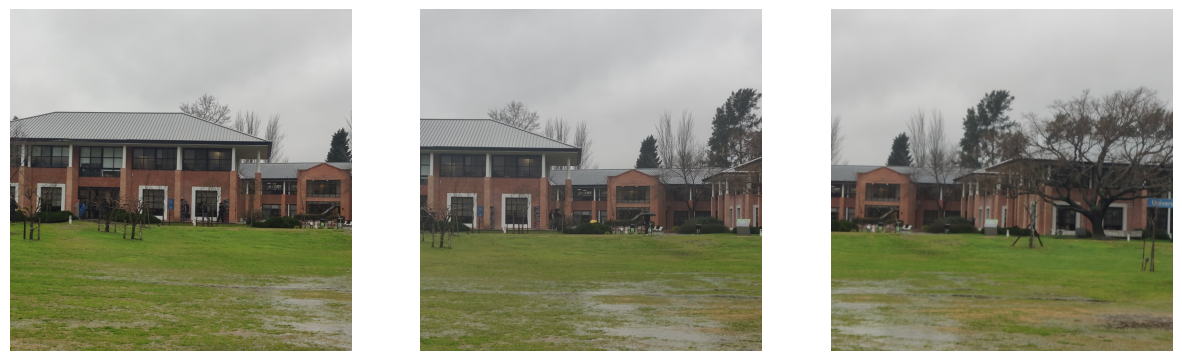

In [1]:


import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

# Ruta de la carpeta que contiene las imágenes
carpeta_imagenes = 'img'

udesa_0 = cv2.imread(os.path.join(carpeta_imagenes, 'udesa_0.jpg'))
udesa_1 = cv2.imread(os.path.join(carpeta_imagenes, 'udesa_1.jpg'))
udesa_2 = cv2.imread(os.path.join(carpeta_imagenes, 'udesa_2.jpg'))

#graficar las imagenes una al lado de la otra
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(udesa_0, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(udesa_1, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(udesa_2, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


# Detección y descripición de características visuales


Imagen 0: 22107 keypoints detectados
Imagen 1: 14852 keypoints detectados
Imagen 2: 5363 keypoints detectados


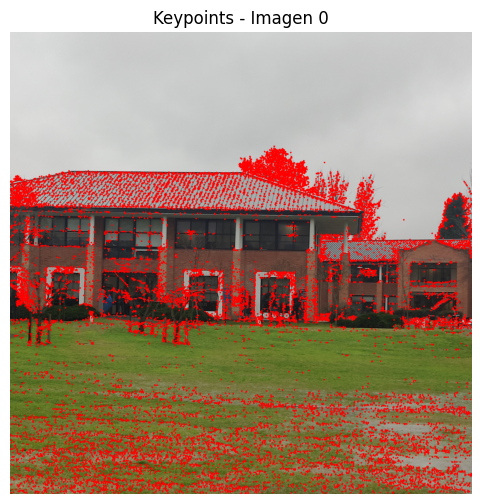

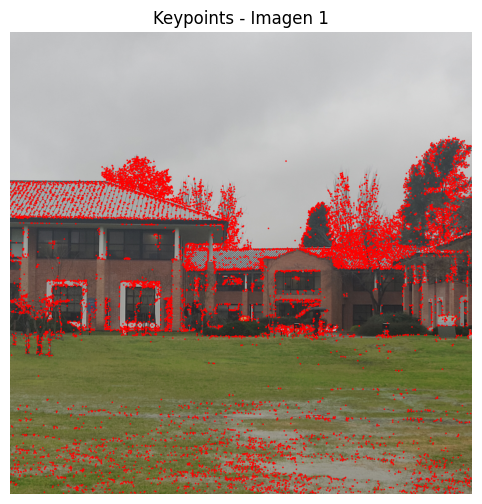

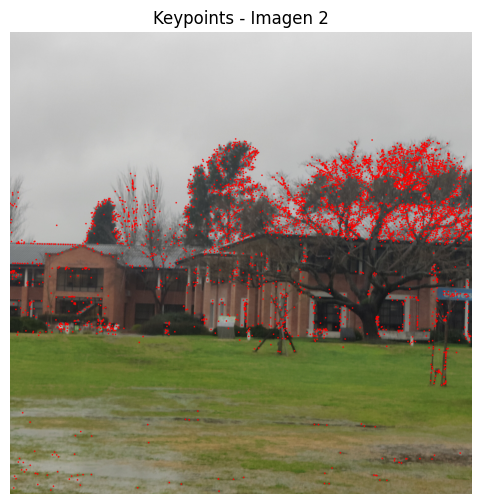

In [2]:
import cv2
import matplotlib.pyplot as plt

def detectar_descriptores(imagen, metodo="ORB", nfeatures=500):
    """
    Detecta keypoints y calcula descriptores de una imagen.
    
    Args:
        imagen (np.array): imagen cargada con cv2.imread
        metodo (str): "SIFT" o "ORB"
        nfeatures (int): cantidad máxima de features
    
    Returns:
        keypoints, descriptors
    """
    if metodo.upper() == "SIFT":
        detector = cv2.SIFT_create(nfeatures=nfeatures)
    elif metodo.upper() == "ORB":
        detector = cv2.ORB_create(nfeatures=nfeatures)
    else:
        raise ValueError("Método no soportado. Usar 'SIFT' u 'ORB'.")

    # detección + descripción en un solo paso
    keypoints, descriptors = detector.detectAndCompute(imagen, None)
    return keypoints, descriptors

def mostrar_keypoints(imagen, keypoints, titulo="Keypoints"):
    img_kp = imagen.copy()
    for kp in keypoints:
        x, y = map(int, kp.pt)
        cv2.circle(img_kp, (x, y), 5, (0,0,255), -1)  # círculos rojos
    plt.figure(figsize=(8,6))
    plt.imshow(cv2.cvtColor(img_kp, cv2.COLOR_BGR2RGB))
    plt.title(titulo)
    plt.axis("off")
    plt.show()

# Detectar descriptores en cada imagen con ORB
kp0, des0 = detectar_descriptores(udesa_0, metodo="SIFT", nfeatures=50000)
kp1, des1 = detectar_descriptores(udesa_1, metodo="SIFT", nfeatures=50000)
kp2, des2 = detectar_descriptores(udesa_2, metodo="SIFT", nfeatures=50000)

print(f"Imagen 0: {len(kp0)} keypoints detectados")
print(f"Imagen 1: {len(kp1)} keypoints detectados")
print(f"Imagen 2: {len(kp2)} keypoints detectados")

# Mostrar imágenes con keypoints dibujados
mostrar_keypoints(udesa_0, kp0, "Keypoints - Imagen 0")
mostrar_keypoints(udesa_1, kp1, "Keypoints - Imagen 1")
mostrar_keypoints(udesa_2, kp2, "Keypoints - Imagen 2")


# 3.2.  Supresión de No Máxima Adaptativa

Imagen 0: 800 keypoints tras ANMS
Imagen 1: 800 keypoints tras ANMS
Imagen 2: 800 keypoints tras ANMS


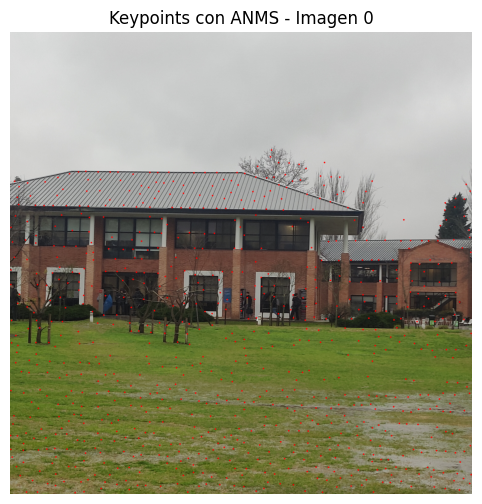

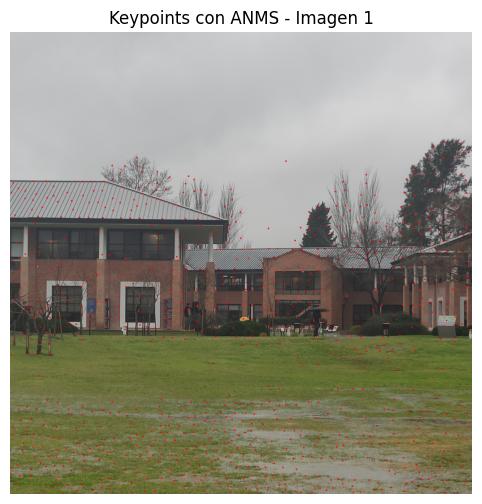

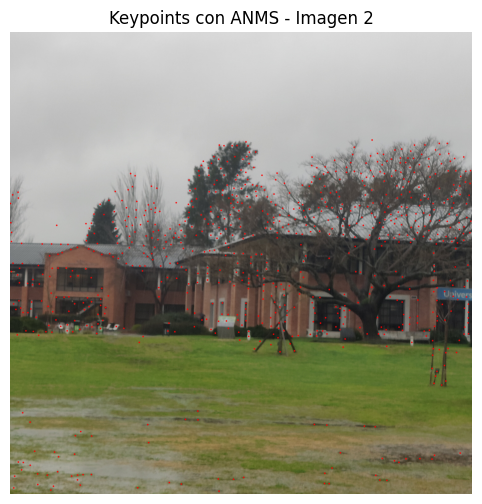

In [3]:

import numpy as np
from scipy.spatial import cKDTree

def aplicar_ANMS(keypoints, N=500):
    """
    ANMS rápido usando KD-Tree.
    
    Args:
        keypoints: lista de cv2.KeyPoint detectados
        N: cantidad máxima de puntos a conservar
    
    Returns:
        keypoints_filtrados: lista reducida de keypoints
    """
    if len(keypoints) <= N:
        return keypoints

    # Extraer coordenadas y respuestas
    coords = np.array([kp.pt for kp in keypoints])
    respuestas = np.array([kp.response for kp in keypoints])

    # Ordenar por respuesta descendente
    idx_sorted = np.argsort(-respuestas)
    coords_sorted = coords[idx_sorted]
    respuestas_sorted = respuestas[idx_sorted]

    # KDTree para búsquedas rápidas
    tree = cKDTree(coords_sorted)

    # Radios inicializados en infinito
    radios = np.full(len(coords_sorted), np.inf)

    # Para cada punto (menos fuerte), buscar el vecino más cercano más fuerte
    for i in range(1, len(coords_sorted)):
        # vecinos más fuertes son los anteriores en el orden
        d, j = tree.query(coords_sorted[i], k=i)  
        radios[i] = np.min(np.sum((coords_sorted[i] - coords_sorted[:i])**2, axis=1))

    # Ordenar por radio descendente
    idx_final = np.argsort(-radios)

    # Seleccionar top N
    seleccionados_idx = idx_final[:N]
    seleccionados = [keypoints[idx_sorted[i]] for i in seleccionados_idx]

    return seleccionados



# Aplicar ANMS para quedarnos con 800 bien distribuidos
kp0_anms = aplicar_ANMS(kp0, N=800)
kp1_anms = aplicar_ANMS(kp1, N=800)
kp2_anms = aplicar_ANMS(kp2, N=800)

print(f"Imagen 0: {len(kp0_anms)} keypoints tras ANMS")
print(f"Imagen 1: {len(kp1_anms)} keypoints tras ANMS")
print(f"Imagen 2: {len(kp2_anms)} keypoints tras ANMS")
# Visualizar resultado
mostrar_keypoints(udesa_0, kp0_anms, "Keypoints con ANMS - Imagen 0")
mostrar_keypoints(udesa_1, kp1_anms, "Keypoints con ANMS - Imagen 1")
mostrar_keypoints(udesa_2, kp2_anms, "Keypoints con ANMS - Imagen 2")


# ASOCIACIÓN DE CARACTERÍSTICAS

Imagen 0: 800 puntos tras ANMS
Imagen 1: 800 puntos tras ANMS
Imagen 2: 800 puntos tras ANMS
Matches entre 0 y 1: 71
Matches entre 2 y 1: 17


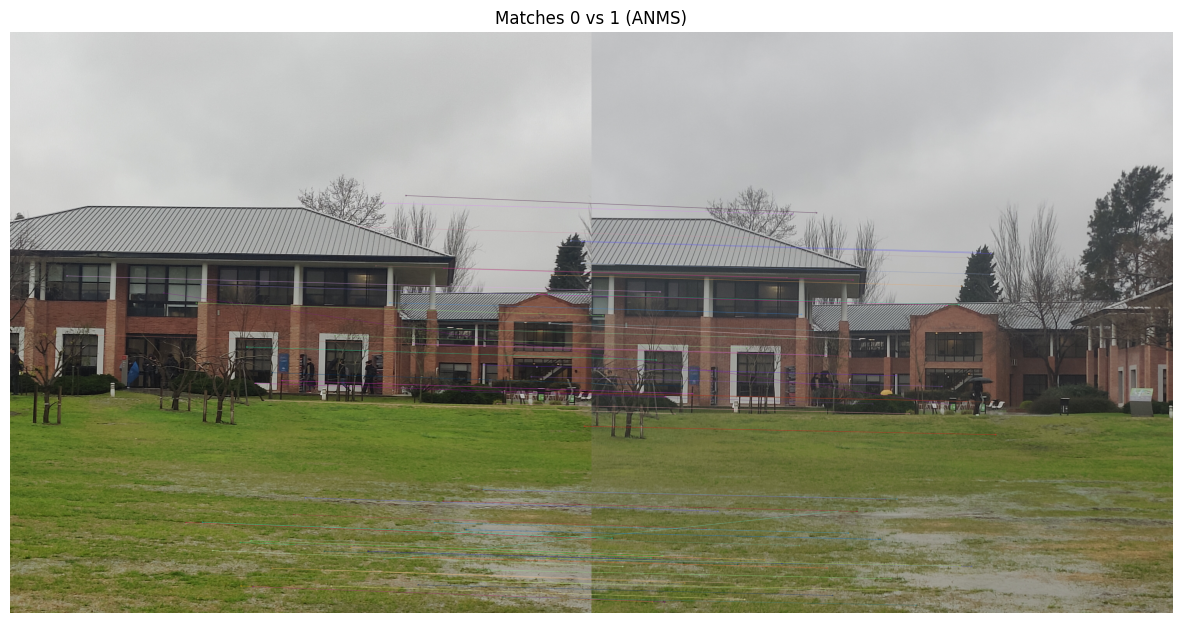

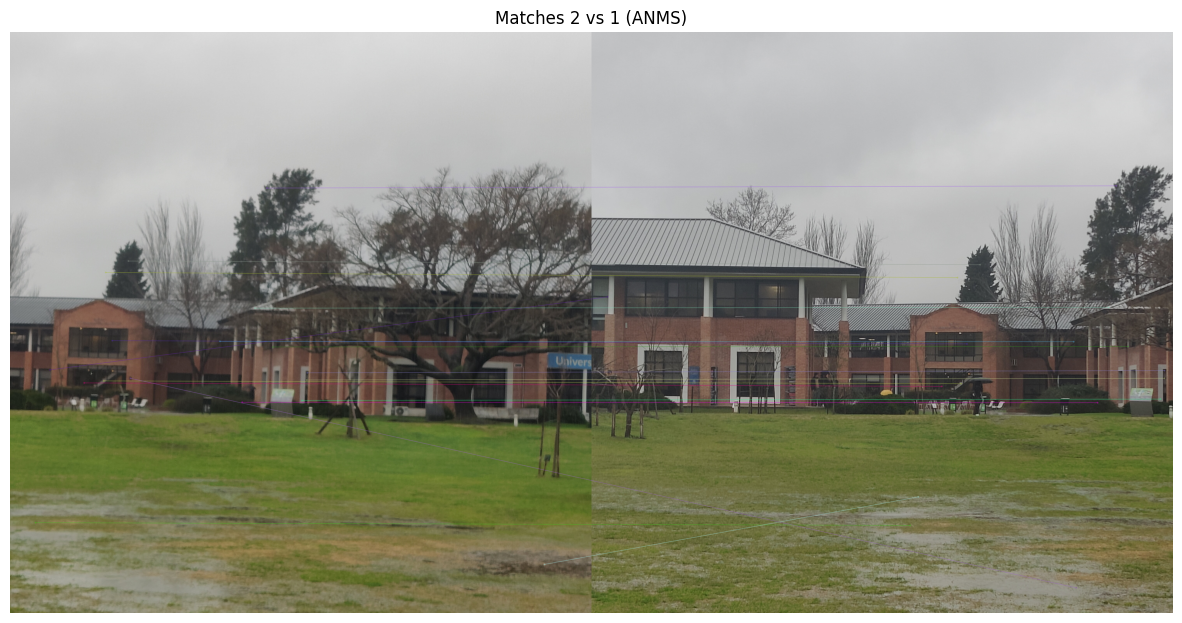

In [ ]:
def filtrar_descriptores(keypoints, descriptores, keypoints_filtrados):
    """
    Retorna exactamente los descriptores correspondientes a los keypoints filtrados.
    """
    set_filtrados = set(keypoints_filtrados)  # conjunto de objetos KeyPoint
    kp_new, des_new = [], []
    for kp, des in zip(keypoints, descriptores):
        if kp in set_filtrados:
            kp_new.append(kp)
            des_new.append(des)
    return kp_new, np.array(des_new)

def match_features(desc1, desc2, metodo="SIFT", ratio=0.75,
                   use_ratio=True, use_cross_check=True):
    """
    Matching entre dos conjuntos de descriptores aplicando:
      - Lowe's ratio test
      - Cross-check
    Permite activar uno, otro, o ambos.
    """
    if metodo.upper() == "SIFT":
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    else:
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)

    # KNN Matching (2 vecinos)
    matches = bf.knnMatch(desc1, desc2, k=2)

    # Aplicar Lowe's ratio (si corresponde)
    if use_ratio:
        buenos = [m for m, n in matches if m.distance < ratio * n.distance]
    else:
        buenos = [m for m, _ in matches]  # tomar el primer vecino
       
    # Aplicar Cross-check (si corresponde)
    if use_cross_check:
        matches_12 = {(m.queryIdx, m.trainIdx) for m in buenos}
        matches_back = bf.knnMatch(desc2, desc1, k=2)

        if use_ratio:
            matches_21 = {
                (m.trainIdx, m.queryIdx)
                for m, n in matches_back if m.distance < ratio * n.distance
            }
        else:
            matches_21 = {(m.trainIdx, m.queryIdx) for m, _ in matches_back}

        interseccion = matches_12 & matches_21
        buenos = [m for m in buenos if (m.queryIdx, m.trainIdx) in interseccion]

    return buenos



def dibujar_matches(img1, kp1, img2, kp2, matches, max_matches, titulo="Matches"):
    """
    Visualiza las correspondencias.
    """
    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:max_matches], None,
                                  flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(15, 8))
    plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
    plt.title(titulo)
    plt.axis("off")
    plt.show()

kp0_final, des0_final = filtrar_descriptores(kp0, des0, kp0_anms)
kp1_final, des1_final = filtrar_descriptores(kp1, des1, kp1_anms)
kp2_final, des2_final = filtrar_descriptores(kp2, des2, kp2_anms)


print(f"Imagen 0: {len(kp0_final)} puntos tras ANMS")
print(f"Imagen 1: {len(kp1_final)} puntos tras ANMS")
print(f"Imagen 2: {len(kp2_final)} puntos tras ANMS")

# Matching (usando la imagen 1 como "ancla")
matches01 = match_features(des0_final, des1_final, metodo="SIFT", ratio=0.75)
matches21 = match_features(des2_final, des1_final, metodo="SIFT", ratio=0.75)

print(f"Matches entre 0 y 1: {len(matches01)}")
print(f"Matches entre 2 y 1: {len(matches21)}")

# Visualizar algunos matches
dibujar_matches(udesa_0, kp0_final, udesa_1, kp1_final, matches01, 800, titulo="Matches 0 vs 1 (ANMS)")
dibujar_matches(udesa_2, kp2_final, udesa_1, kp1_final, matches21, 800, titulo="Matches 2 vs 1 (ANMS)")  